In [2]:
#This file implements the Locality-Sensitive_Hashing algorithm to find pairs of lines that have 0.85 or higher Jaccard Similarity in 10^6 lines
import random
import itertools # for getting pairs
import numpy as np
import seaborn as sns
import mmh3
import math # for log
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
#Part 1
def jaccard_similarity(s1, s2):
    intersection = len(set(s1)& set(s2))
    union = len(s1) + len(s2) - intersection
    return intersection/union

#time complexity of computing JS = O(min(len(s1), len(s2))) = O(k)
#In order to compute JS each of n choose 2 pairs of sets, it will take O(kn^2) time, because there are O(n^2) pairs and each JS computation takes O(k), where k is the minimum length between two sets

In [4]:
#Part 2
with open('./data.txt', 'r') as f:
    lines = f.read().splitlines()
    for i in range(len(lines)):
        lines[i] = lines[i].strip().split()


In [ ]:
sample_size = 5000
random_sample = random.sample(lines, sample_size)
pairs_sample = list(itertools.combinations(random_sample, 2))
js_sample = []
for pair in pairs_sample:
    js_sample.append(jaccard_similarity(set(pair[0].split(' ')), set(pair[1].split(' '))))



<AxesSubplot:ylabel='Density'>

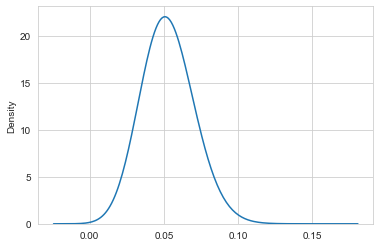

In [5]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(js_sample), bw=0.5)
#most of the points have js of 0.05

In [7]:
#Part 3: Determining the optimal number of k,b,r (k=b*r)
import scipy.optimize as opt
import math

def choose_nbands(t, n):
    def error_fun(x):
        cur_t = (1/x[0])**(x[0]/n)
        return (t-cur_t)**2

    opt_res = opt.minimize(error_fun, x0=(10), method='Nelder-Mead')
    b = int(math.ceil(opt_res['x'][0]))
    r = int(n / b)
    final_t = (1/b)**(1/r)
    return b, r,final_t

In [35]:
k=21
b,r, t = choose_nbands(0.85,k)
print(b,r,t)
k=b*r

4 5 0.757858283255199


E:\Courseware\Fall 2020\Algo Found of Data Sci\pyspark_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


int(num) here is the row number, for each number in each line, we hash it k times, and we take the minimum of the hashed row number as the signature index. We initiaze the hashedlist to be maximum of 32 bit integer+1. Each line(document) will generate k-bit long signature vector, we store them in the dictionary with the lineIndex(docId, starting with 1) as keys.

In [36]:
def fill_sketch_minhash(line,k):
    hashedList = {}
    c = 0
    for seed in range(2*k):
        for num in line:
            val = mmh3.hash(num,seed=seed+5)
            bins = seed if seed<k else seed-k
            if hashedList.setdefault(bins,(2147483647+1)) == (2147483647+1):
                c+=1
            hashedList[bins] = min(hashedList[bins],val)
        if c==k:
            return [val for key, val in sorted(hashedList.items())]

In [37]:
def minhash(line,k):
    hashedList = ['infty']*k
    for num in line:
        for seed in range(k):
            val = mmh3.hash(num,seed=seed,signed=False)
            #hashedList[seed] = min(hashedList.setdefault(seed,(2147483647+1)),val)
            if(hashedList[seed]=='infty'):
                hashedList[seed]= val
            else:
                hashedList[seed] = min(hashedList[seed],val)
    return list(map(str,hashedList))

In [ ]:
linesMinHashed = {}
for lineID in range(len(lines)):
    linesMinHashed[lineID] = minhash(lines[lineID],k)
    if lineID%10000==0:
        print(lineID)

In [ ]:
candidate_pairs=[]
for banding in range(b):
    LSHash={}
    start = banding*r
    end = min(banding*r+r,k)
    for lineID in linesMinHashed:
        banded = ''.join(linesMinHashed[lineID][start:end])
        if (not banded):
                continue
        #print(banded)
        sig_hashed = mmh3.hash(banded,seed=banding+10)
        # cand_list = LSHash.setdefault(sig_hashed,[])
        # LSHash[sig_hashed] = cand_list.append(line)
        if(LSHash.get(sig_hashed,'NaN') == 'NaN'):
            LSHash[sig_hashed] = [lineID]
        else:
            LSHash[sig_hashed].append(lineID)
        #if(lineID%10000==0):
            #print(lineID)

    for key, val in LSHash.items():
        if(len(val)>1):
            print(key,len(val))
            candidate_pairs.append(list(itertools.combinations(val,2)))

In [45]:
len(candidate_pairs)

418675

In [ ]:
final_pairs = []
for line in candidate_pairs:
    for tup in line:
        js = jaccard_similarity(lines[tup[0]],lines[tup[1]])
        print(js)
        if js>0.85:
            final_pairs.append(tup)

In [48]:
final_pairs

[(77683, 124849),
 (215149, 274946),
 (318540, 752337),
 (77683, 124849),
 (318540, 752337),
 (215149, 274946),
 (318540, 752337),
 (77683, 124849),
 (167121, 479963),
 (215149, 274946)]

In [50]:
ans = final_pairs
ans

{(77683, 124849), (167121, 479963), (215149, 274946), (318540, 752337)}

In [53]:
for tup in ans:
    print('Line {} and {} have jaccard similarity of: {}'.format(tup[0],tup[1],jaccard_similarity(lines[tup[0]],lines[tup[1]])))

Line 167121 and 479963 have jaccard similarity of: 0.9051724137931034
Line 77683 and 124849 have jaccard similarity of: 0.8636363636363636
Line 215149 and 274946 have jaccard similarity of: 0.8916666666666667
Line 318540 and 752337 have jaccard similarity of: 0.8596491228070176
